In [1]:
# The term you are looking for to find the best choice of parameters when you have data values:
# supervised dimensionality reduction

%pylab inline
#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.optimize as optimize

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib
matplotlib.__version__

'2.0.0rc1'

In [3]:
import h5py

In [4]:
sys.path.insert(0, '../../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2
import gaussianprocessregression as gpr
import designofexperiment as doe
#import pycbcwaveform as pycbcwave
import lalwaveform
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(taylorf2)
imp.reload(gpr)
imp.reload(doe)
#imp.reload(pycbcwave)
imp.reload(lalwaveform)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)

import constants
imp.reload(constants)
from constants import *

# Get saved training-set waveforms

In [17]:
# trainset = ws.HDF5WaveformSet('../../data/TEOBv4_20hz/dh_train_corners_lhd.hdf5')
# amp_gp_filename = '../../data/TEOBv4_20hz/gp_spline_amp_corners_lhd.hdf5'
# phase_gp_filename = '../../data/TEOBv4_20hz/gp_spline_phase_corners_lhd.hdf5'
# nodes_filename = '../../data/TEOBv4_20hz/nodes_corners_lhd.hdf5'

# trainset = ws.HDF5WaveformSet('../../data/TEOBv4_20hz/dh_train_lhd_uncsamp.hdf5')
# amp_gp_filename = '../../data/TEOBv4_20hz/gp_spline_amp_lhd_uncsamp.hdf5'
# phase_gp_filename = '../../data/TEOBv4_20hz/gp_spline_phase_lhd_uncsamp.hdf5'
# nodes_filename = '../../data/TEOBv4_20hz/nodes_lhd_uncsamp.hdf5'

trainset = ws.HDF5WaveformSet('../../data/TEOBv4_20hz/dh_train_lhd_uncsamp_rand.hdf5')
amp_gp_filename = '../../data/TEOBv4_20hz/gp_spline_amp_lhd_uncsamp_rand.hdf5'
phase_gp_filename = '../../data/TEOBv4_20hz/gp_spline_phase_lhd_uncsamp_rand.hdf5'
nodes_filename = '../../data/TEOBv4_20hz/nodes_lhd_uncsamp_rand.hdf5'


# Manually specify locations of interpolating nodes
namp = 40
nphase = 39
h = trainset[0]
amp_mfs = np.logspace(np.log10(h.x[0]), np.log10(h.x[-1]), namp)
phase_mfs = np.logspace(np.log10(h.x[0]), np.log10(h.x[-1]), nphase+1)
phase_mfs = np.delete(phase_mfs, 0)

print trainset.parameters().shape
print len(amp_mfs), amp_mfs
print len(phase_mfs), phase_mfs

(1359, 5)
40 [ 0.00021     0.00024373  0.00028288  0.00032831  0.00038104  0.00044225
  0.00051328  0.00059572  0.00069141  0.00080246  0.00093135  0.00108094
  0.00125455  0.00145606  0.00168993  0.00196136  0.00227639  0.00264202
  0.00306637  0.00355889  0.00413051  0.00479394  0.00556393  0.0064576
  0.0074948   0.0086986   0.01009575  0.0117173   0.01359931  0.0157836
  0.01831873  0.02126104  0.02467594  0.02863933  0.03323931  0.03857814
  0.04477447  0.05196604  0.06031271  0.07      ]
39 [ 0.00024373  0.00028288  0.00032831  0.00038104  0.00044225  0.00051328
  0.00059572  0.00069141  0.00080246  0.00093135  0.00108094  0.00125455
  0.00145606  0.00168993  0.00196136  0.00227639  0.00264202  0.00306637
  0.00355889  0.00413051  0.00479394  0.00556393  0.0064576   0.0074948
  0.0086986   0.01009575  0.0117173   0.01359931  0.0157836   0.01831873
  0.02126104  0.02467594  0.02863933  0.03323931  0.03857814  0.04477447
  0.05196604  0.06031271  0.07      ]


In [18]:
# Write the nodes hdf5 file
f = h5py.File(nodes_filename)
f['amp_mfs'] = amp_mfs
f['phase_mfs'] = phase_mfs
f.close()

1359


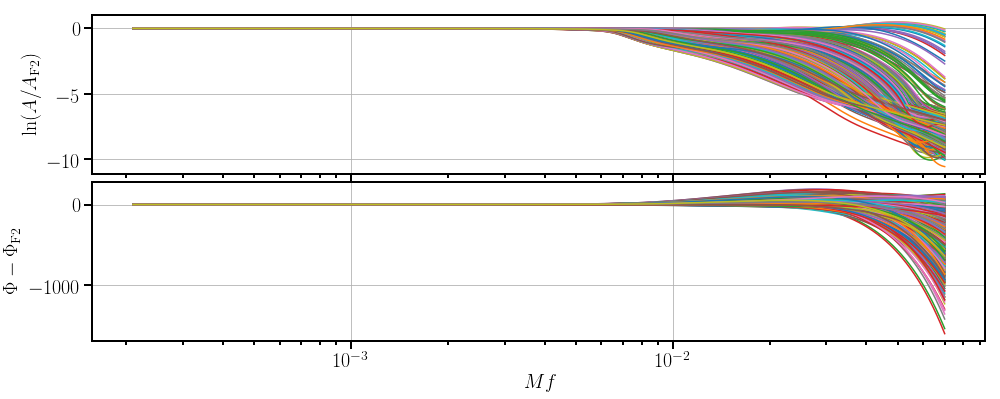

In [19]:
print len(trainset)

fig, (ax1, ax2) = wave.plot_waveforms_fd([trainset[i] for i in range(0, len(trainset), 1)])
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

# Generate Gaussian processes

In [20]:
# Calculate the amplitude for all waveforms in the training set
# at the amplitude empirical nodes
damp_ts_list = []
for j in range(len(amp_mfs)):
    mf = amp_mfs[j]
    damp_ts = np.array([trainset[i].interpolate('amp')(mf) for i in range(len(trainset))])
    damp_ts_list.append(damp_ts)
    
# Calculate the phase for all waveforms in the training set
# at the phase empirical nodes
dphase_ts_list = []
for j in range(len(phase_mfs)):
    mf = phase_mfs[j]
    dphase_ts = np.array([trainset[i].interpolate('phase')(mf) for i in range(len(trainset))])
    dphase_ts_list.append(dphase_ts)
    
# Relevant parameters for the training set waveforms
params_ts = trainset.parameters()

In [21]:
limits = np.array([[1.0/3.0, 1.0], [-0.5, 0.5], [-0.5, 0.5], [0, 5000], [0, 5000]])
kernel_type = 'matern52'

damp_gp_list = []
for i in range(len(damp_ts_list)):
    print i
    points = params_ts
    data = damp_ts_list[i]
    hp0, hyper_limits = gpr.reasonable_hyperparameters_range(data, limits)
    damp_gp = gpr.generate_gp(points, data, hp0, kernel_type=kernel_type, 
                                hyper_limits=hyper_limits, n_restarts_optimizer=9)
    
    print gpr.get_hyperparameters(damp_gp)
    damp_gp_list.append(damp_gp)

0
[  6.23619131e-04   1.85443557e+00   3.07707935e+00   4.00000000e+00
   2.00000000e+04   2.00000000e+04   1.39600527e-08]
1
[  6.71807607e-04   1.84253579e+00   3.07089672e+00   4.00000000e+00
   2.00000000e+04   2.00000000e+04   1.55035513e-08]
2
[  7.60735013e-04   1.84294123e+00   3.08589859e+00   4.00000000e+00
   2.00000000e+04   2.00000000e+04   1.82730543e-08]
3
[  8.62545671e-04   1.84599106e+00   3.08097073e+00   4.00000000e+00
   2.00000000e+04   2.00000000e+04   2.16124100e-08]
4
[  9.67241233e-04   1.83286507e+00   3.08481379e+00   4.00000000e+00
   2.00000000e+04   2.00000000e+04   2.55287288e-08]
5
[  1.10053945e-03   1.79257983e+00   3.07436115e+00   4.00000000e+00
   2.00000000e+04   2.00000000e+04   3.01173965e-08]
6
[  1.25152945e-03   1.82319095e+00   3.10006977e+00   4.00000000e+00
   2.00000000e+04   2.00000000e+04   3.57215692e-08]
7
[  1.39258811e-03   1.80051210e+00   3.10144025e+00   4.00000000e+00
   2.00000000e+04   2.00000000e+04   4.23223918e-08]
8
[  1.5

In [22]:
limits = np.array([[1.0/3.0, 1.0], [-0.5, 0.5], [-0.5, 0.5], [0, 5000], [0, 5000]])
kernel_type = 'matern52'

dphase_gp_list = []
for i in range(len(dphase_ts_list)):
    print i
    points = params_ts
    data = dphase_ts_list[i]
    hp0, hyper_limits = gpr.reasonable_hyperparameters_range(data, limits, length_scale_factor=[0.1, 10.0], 
                                                             sigma_n_factor=[1.0e-6, 0.1])
    #print hyper_limits
    dphase_gp = gpr.generate_gp(points, data, hp0, kernel_type=kernel_type, 
                                hyper_limits=hyper_limits, n_restarts_optimizer=9)
    
    print gpr.get_hyperparameters(dphase_gp)
    dphase_gp_list.append(dphase_gp)

0
[  1.24645551e-03   1.34305522e+00   1.71954920e+00   4.49671994e+00
   2.56841757e+04   3.82535673e+04   1.31703606e-05]
1
[  2.06206092e-02   1.86706274e+00   2.91247555e+00   7.14999060e+00
   2.56027516e+04   4.35180196e+04   4.56041938e-05]
2
[  5.58408564e-02   1.79723722e+00   2.99995365e+00   7.18958802e+00
   2.26186102e+04   4.14285202e+04   7.82353430e-05]
3
[  1.14188924e-01   1.77998651e+00   3.05665870e+00   7.23318413e+00
   2.18656754e+04   4.18225492e+04   1.14726904e-04]
4
[  2.01635383e-01   1.78145590e+00   3.11341545e+00   7.28455245e+00
   2.15918691e+04   4.26365643e+04   1.55786674e-04]
5
[  3.25421469e-01   1.79467170e+00   3.16932273e+00   7.35839874e+00
   2.13960763e+04   4.36555278e+04   2.00655870e-04]
6


/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -4.51821855e+00,  -6.64049272e-03,  -7.94930192e-04,
         1.31345812e-02,   1.51814057e-02,   1.21962329e-02,
        -2.56781809e-03]), 'nit': 48, 'funcalls': 104}
  " state: %s" % convergence_dict)


[  4.94449966e-01   1.81219316e+00   3.22118799e+00   7.44382767e+00
   2.14420621e+04   4.46376722e+04   2.51092047e-04]
7
[  7.19287567e-01   1.83088903e+00   3.27234785e+00   7.53851075e+00
   2.15423905e+04   4.56382989e+04   3.06636823e-04]
8
[  1.01274163e+00   1.85007788e+00   3.32258409e+00   7.63886378e+00
   2.17203639e+04   4.66066781e+04   3.68442532e-04]
9


/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -2.86493460e+00,  -4.19215745e-02,  -7.68244369e-03,
        -3.57727990e-02,  -1.29510719e-02,  -1.22227432e-04,
        -2.68474283e-04]), 'nit': 22, 'funcalls': 67}
  " state: %s" % convergence_dict)


[  1.39018644e+00   1.86964077e+00   3.37173425e+00   7.74264785e+00
   2.19596228e+04   4.75335399e+04   4.37586628e-04]
10
[  1.87032005e+00   1.88918290e+00   3.42009844e+00   7.84958026e+00
   2.22485453e+04   4.84201099e+04   5.15254581e-04]
11
[  2.47475839e+00   1.90849742e+00   3.46738723e+00   7.95710816e+00
   2.25698767e+04   4.92695779e+04   6.02562259e-04]
12
[  3.23099201e+00   1.92792124e+00   3.51436316e+00   8.06736866e+00
   2.29406379e+04   5.00000000e+04   7.01103324e-04]
13


/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -5.20843540e+00,  -6.63094582e-03,   2.39962311e-02,
        -3.79950472e-03,  -5.71408490e-03,  -5.42950219e+00,
         3.41696106e-03]), 'nit': 29, 'funcalls': 81}
  " state: %s" % convergence_dict)


[  4.17162413e+00   1.94851711e+00   3.56330261e+00   8.18401445e+00
   2.34862969e+04   5.00000000e+04   8.10076855e-04]
14
[  5.33695843e+00   1.96856973e+00   3.61257153e+00   8.30362999e+00
   2.40574097e+04   5.00000000e+04   9.31954167e-04]
15
[  6.77756006e+00   1.98786056e+00   3.66260283e+00   8.42768131e+00
   2.46780357e+04   5.00000000e+04   1.06830670e-03]
16
[  8.55848415e+00   2.00711967e+00   3.71452027e+00   8.55648528e+00
   2.53327082e+04   5.00000000e+04   1.22025347e-03]
17


/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-6.12477871, -0.03525706, -0.02670749,  0.0229273 , -0.02150622,
       -0.03198388, -0.01827709]), 'nit': 21, 'funcalls': 69}
  " state: %s" % convergence_dict)


[  1.07667182e+01   2.02781164e+00   3.77202336e+00   8.69682194e+00
   2.60459214e+04   5.00000000e+04   1.38689898e-03]
18


/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -4.90388950e+00,   9.13053530e-03,   2.81553844e-03,
         7.19785828e-03,   6.13460402e-03,  -7.14586000e+00,
        -1.52009534e-02]), 'nit': 34, 'funcalls': 86}
  " state: %s" % convergence_dict)


[  1.35752135e+01   2.05096502e+00   3.84059256e+00   8.87065529e+00
   2.69251381e+04   5.00000000e+04   1.57549817e-03]
19
[  1.71137329e+01   2.07292202e+00   3.92105970e+00   9.08058935e+00
   2.78782241e+04   5.00000000e+04   1.79457287e-03]
20
[  2.04191610e+01   2.04747389e+00   3.92118963e+00   9.10270147e+00
   2.77681456e+04   5.00000000e+04   2.01648066e-03]
21


/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -6.96710683e-03,   9.26875802e-03,   1.07727784e-02,
         6.55424145e-03,   7.72199435e-03,  -3.77885334e+01,
        -9.31545541e-04]), 'nit': 16, 'funcalls': 65}
  " state: %s" % convergence_dict)


[  2.42163099e+01   2.00412403e+00   3.92704859e+00   9.13364315e+00
   2.76272801e+04   5.00000000e+04   2.41166484e-03]
22
[  2.69822176e+01   1.86271928e+00   3.87115878e+00   9.01411491e+00
   2.57815577e+04   5.00000000e+04   2.46523491e-03]
23
[  2.79907228e+01   1.58977956e+00   3.77038311e+00   8.82539239e+00
   2.14894565e+04   5.00000000e+04   2.06446606e-03]
24
[  3.14510458e+01   1.42697186e+00   3.80925825e+00   8.79084103e+00
   1.95735924e+04   5.00000000e+04   3.11323092e-05]
25


/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.20828361e-02,   2.70391573e-02,   4.23200293e-02,
         1.92567845e-03,  -5.68327828e-03,  -1.63682445e+02,
         4.60480575e-03]), 'nit': 17, 'funcalls': 66}
  " state: %s" % convergence_dict)


[  3.93430437e+01   1.36926707e+00   3.92507112e+00   9.17655113e+00
   1.78809345e+04   5.00000000e+04   4.83643110e-05]
26
[  4.96014478e+01   1.37558415e+00   4.10100796e+00   9.51864105e+00
   1.59730385e+04   5.00000000e+04   6.98301863e-05]
27
[  6.74032669e+01   1.42423196e+00   4.36856161e+00   9.80057081e+00
   1.46150058e+04   5.00000000e+04   9.44327967e-05]
28


/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -2.15667668e-02,   1.20498939e-02,   2.07648666e-02,
        -1.49967731e+01,   1.13488792e-02,  -1.56363359e+02,
         9.91044247e-04]), 'nit': 35, 'funcalls': 79}
  " state: %s" % convergence_dict)


[  9.06030987e+01   1.45115540e+00   4.60408168e+00   1.00000000e+01
   1.40591485e+04   5.00000000e+04   1.20757945e-04]
29
[  1.18961192e+02   1.46578471e+00   4.76486450e+00   1.00000000e+01
   1.40651722e+04   5.00000000e+04   1.46909272e-04]
30


/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -4.30898927e-03,  -3.15630765e-04,   1.19725190e-03,
        -8.31497511e+01,   4.42727028e-03,  -5.45316250e+01,
         7.68909683e-04]), 'nit': 44, 'funcalls': 132}
  " state: %s" % convergence_dict)
/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.12523437e-02,  -1.92887017e-02,  -5.89023233e-03,
        -8.31555723e+01,  -3.46521526e-02,  -5.45364564e+01,
         7.68947143e-04]), 'nit': 36, 'funcalls': 91}
  " state: %s" % convergence_dict)
/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b t

[  1.60200991e+02   1.51199004e+00   4.99688481e+00   1.00000000e+01
   1.44945458e+04   5.00000000e+04   1.70257979e-04]
31


/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -4.50163055e-03,   1.47785692e-02,   2.89323781e-03,
        -1.24731689e+02,   6.14687210e-03,   5.95004055e-03,
         5.60312188e-04]), 'nit': 37, 'funcalls': 84}
  " state: %s" % convergence_dict)
/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.52613036e-04,   1.04312083e-03,   7.40622232e-04,
        -1.24726654e+02,  -1.36719150e-03,   1.77317778e-03,
         5.60318047e-04]), 'nit': 39, 'funcalls': 90}
  " state: %s" % convergence_dict)
/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b te

[  2.14691274e+02   1.57822177e+00   5.23777066e+00   1.00000000e+01
   1.47682370e+04   4.89076137e+04   1.87079229e-04]
32


/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  2.25892821e-02,  -3.25847247e-02,  -1.04642014e-02,
        -1.25964430e+02,  -2.74500528e-02,  -2.13260732e-02,
         3.34290622e-04]), 'nit': 38, 'funcalls': 84}
  " state: %s" % convergence_dict)


[  2.52994676e+02   1.56619672e+00   5.19771902e+00   1.00000000e+01
   1.39549615e+04   4.37020415e+04   1.92043152e-04]
33
[  2.99523236e+02   1.56080317e+00   5.19882505e+00   1.00000000e+01
   1.30424942e+04   3.94988357e+04   1.80176959e-04]
34
[  3.59319677e+02   1.56701973e+00   5.23030873e+00   1.00000000e+01
   1.21209034e+04   3.64041328e+04   2.39139838e-04]
35
[  4.43010205e+02   1.58567912e+00   5.33127769e+00   1.00000000e+01
   1.12626849e+04   3.45547944e+04   4.15092611e-04]
36


/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -2.31003924e-03,   4.78589215e-03,   7.45132777e-03,
        -1.41668619e+02,   7.12426037e-04,  -2.48037054e-03,
         1.17869722e-05]), 'nit': 28, 'funcalls': 78}
  " state: %s" % convergence_dict)


[  5.61021041e+02   1.60670668e+00   5.58879134e+00   1.00000000e+01
   1.05324200e+04   3.19421611e+04   2.12739990e-02]
37


/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  6.94808956e-03,   2.25882864e-03,  -1.38581285e-02,
        -1.11041724e+02,   7.06033406e-03,  -1.63419354e-02,
        -1.07775208e-04]), 'nit': 27, 'funcalls': 72}
  " state: %s" % convergence_dict)


[  7.65420547e+02   1.54357030e+00   5.68013545e+00   1.00000000e+01
   1.00882292e+04   2.87044185e+04   1.28051961e-01]
38


/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.34082707e-02,  -2.26778781e-02,  -1.48053797e-02,
        -1.25173504e+02,  -1.87458407e-03,  -1.25264055e-02,
         3.67024414e-04]), 'nit': 19, 'funcalls': 62}
  " state: %s" % convergence_dict)


[  9.59416913e+02   1.49174152e+00   5.95548611e+00   1.00000000e+01
   9.84663889e+03   2.73263052e+04   3.62180489e-01]


In [23]:
# Save GPR functions
gpr.save_gaussian_process_regression_list(amp_gp_filename, damp_gp_list, 'matern52')
gpr.save_gaussian_process_regression_list(phase_gp_filename, dphase_gp_list, 'matern52')

# Test GPSplineSurrogate class

In [24]:
trainset = ws.HDF5WaveformSet('../../data/TEOBv4_20hz/h_train_corners_lhd.hdf5')
dtrainset = ws.HDF5WaveformSet('../../data/TEOBv4_20hz/dh_train_corners_lhd.hdf5')

# testset_rand = ws.HDF5WaveformSet('../../data/TEOBv4_40hz/h_test2.hdf5')
# dtestset_rand = ws.HDF5WaveformSet('../../data/TEOBv4_40hz/dh_test2.hdf5')

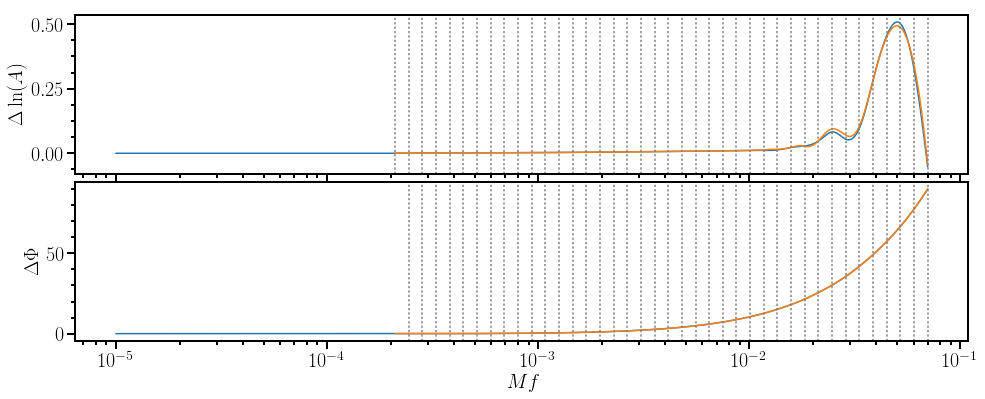

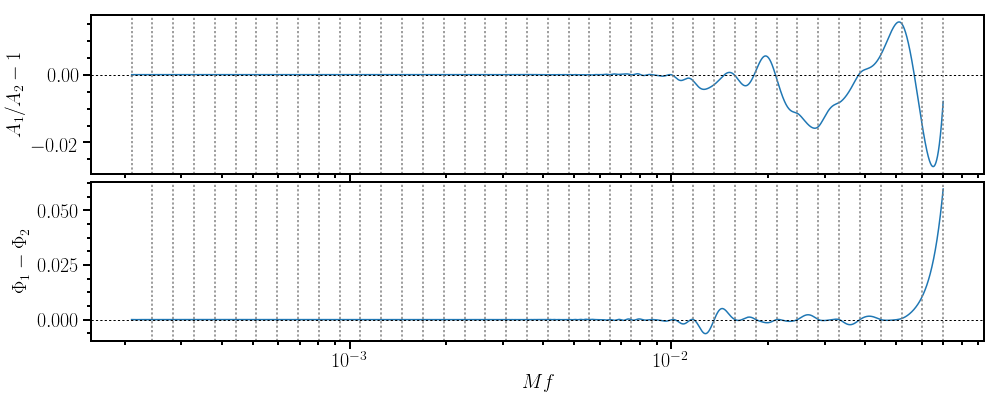

In [25]:
# nodes_filename = '../../data/TEOBv4_20hz/nodes_corners_lhd.hdf5'
# gp_amp_filename = '../../data/TEOBv4_20hz/gp_spline_amp_corners_lhd.hdf5'
# gp_phase_filename = '../../data/TEOBv4_20hz/gp_spline_phase_corners_lhd.hdf5'
# sur = surrogate.GPSplineSurrogate.load(nodes_filename, gp_amp_filename, gp_phase_filename, order=3, npoints=10000)

# nodes_filename = '../../data/TEOBv4_20hz/nodes_lhd_uncsamp.hdf5'
# gp_amp_filename = '../../data/TEOBv4_20hz/gp_spline_amp_lhd_uncsamp.hdf5'
# gp_phase_filename = '../../data/TEOBv4_20hz/gp_spline_phase_lhd_uncsamp.hdf5'
# sur = surrogate.GPSplineSurrogate.load(nodes_filename, gp_amp_filename, gp_phase_filename, order=3, npoints=10000)

nodes_filename = '../../data/TEOBv4_20hz/nodes_lhd_uncsamp_rand.hdf5'
gp_amp_filename = '../../data/TEOBv4_20hz/gp_spline_amp_lhd_uncsamp_rand.hdf5'
gp_phase_filename = '../../data/TEOBv4_20hz/gp_spline_phase_lhd_uncsamp_rand.hdf5'
sur = surrogate.GPSplineSurrogate.load(nodes_filename, gp_amp_filename, gp_phase_filename, order=3, npoints=10000)

i = 28
htest = trainset[i]
dhtest = dtrainset[i]
params = dtrainset.get_waveform(i, data='parameters')

# i = 0
# dhtest = dtestset_rand[i]
# params = dtestset_rand.get_waveform(i, data='parameters')

hsur = sur.geometric_waveform(params)
hf2 = sur.geometric_reference_waveform(params)
dhsur = sur.amp_phase_difference(params)

# Resample
hsur.resample(htest.x)
hsur.phase -= hsur.phase[0]

fig, (ax1, ax2) = wave.plot_waveforms_fd([dhsur, dhtest])
for mf in sur.mf_amp:
    ax1.axvline(mf, c='gray', ls=':')
for mf in sur.mf_phase:
    ax2.axvline(mf, c='gray', ls=':')
#ax1.set_ylim(-0.01, 0.01)
# ax2.set_ylim(-1, 0.1)
ax1.minorticks_on()
ax2.minorticks_on()
ax1.set_ylabel(r'$\Delta\ln(A)$')
ax2.set_ylabel(r'$\Delta\Phi$')
ax2.set_xlabel(r'$Mf$')

fig, (ax1, ax2) = wave.plot_waveform_difference_fd(hsur, htest)
for mf in sur.mf_amp:
    ax1.axvline(mf, c='gray', ls=':')
for mf in sur.mf_phase:
    ax2.axvline(mf, c='gray', ls=':')
# ax1.set_ylim(-0.05, 0.05)
# ax2.set_ylim(-0.1, 0.1)
ax1.minorticks_on()
ax2.minorticks_on()
# ax1.set_ylabel(r'$\Delta\ln(A)_{\rm Sur}/\Delta\ln(A)_{\rm Test} - 1$')
# ax2.set_ylabel(r'$\Delta\Phi_{\rm Sur}-\Delta\Phi_{\rm Test}$')
ax2.set_xlabel(r'$Mf$')

(<matplotlib.figure.Figure at 0x12bbb8d10>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x125fb87d0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1261cf410>))

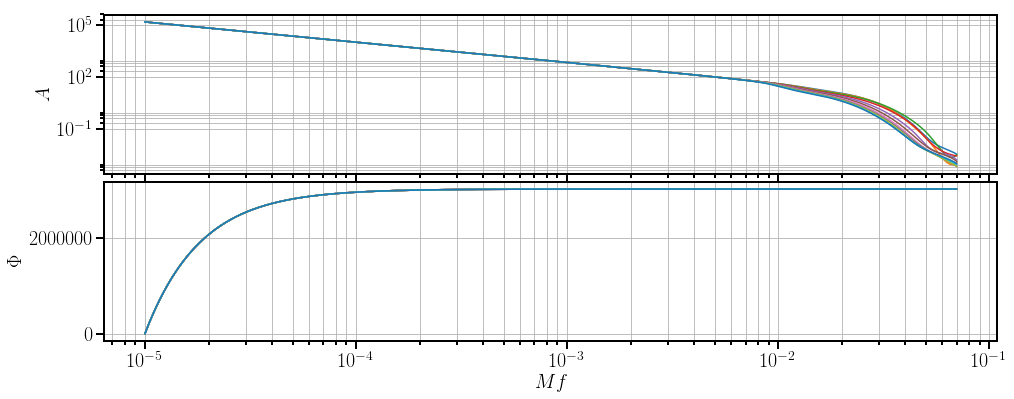

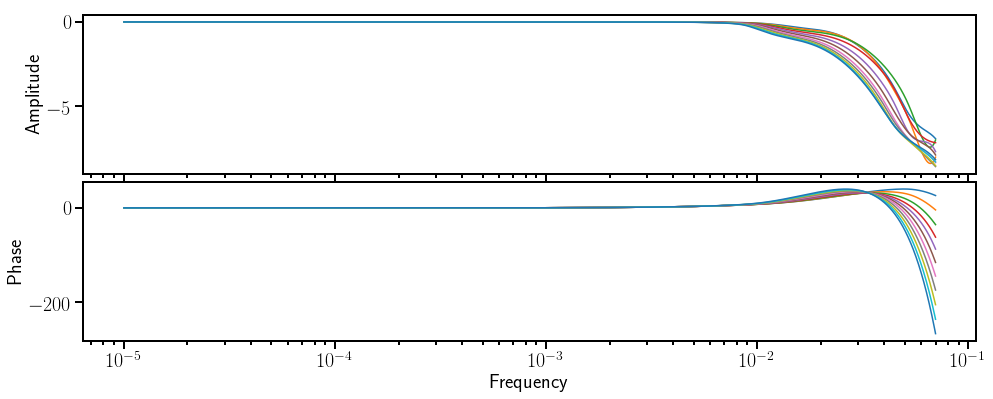

In [26]:
# Vary 1 parameter

q = 1.0
s1 = 0.3
s2 = 0.1
lambda1 = 1000.
lambda2 = 1000.
ps = np.array([[q, s1, s2, lambda1, lambda2] for lambda1 in np.linspace(0, 5000., 11)])

hs = [sur.geometric_waveform(p) for p in ps]
dhs = [sur.amp_phase_difference(p) for p in ps]

fig, (ax1, ax2) = wave.plot_waveforms_fd(hs)
ax1.set_yscale('log')
ax1.set_ylabel(r'$A$')
ax2.set_ylabel(r'$\Phi$')
ax2.set_xlabel(r'$Mf$')
ax1.grid(which='both')
ax2.grid(which='both')

wave.plot_waveforms_fd(dhs)